# **불용어 제거 및 표준화**
- 한 행 씩 보면서, 불용어 표준화 진행을 위한 전처리를 먼저 수행

## **한국어: Requirement, Preference**

In [4]:
import re
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from konlpy.tag import Okt
from ckonlpy.tag import Twitter as Okt
from ckonlpy.tag import Postprocessor
from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

logging.getLogger('konlpy').setLevel(logging.ERROR)

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

code_path = '/VSC/JJaemni/Code/'
csv_path = '/VSC/JJaemni/CSV/'

df = pd.read_csv(csv_path + 'wanted_jobplanet_2.csv')



# 리스트 형태로 불러오기
def text_list_load(text_path):
    with open(text_path, 'r', encoding='utf-8-sig') as file:
        L = [line.strip() for line in file.readlines()]
    return L

# 딕셔너리 형태로 불러오기
def text_dict_load(text_path):
    L = dict()
    with open(text_path, 'r', encoding='utf-8-sig') as file:
        for line in file:
            key, val = line.strip().split(': ')
            L[key] = val
    return L



## Requirement : KOR

# 한글, 영문 대소문자, 숫자, 공백을 제외한 문자를 제거
def Korean_preprocessing(col):
    col_list = df[col].tolist()
    col_list2 = []
    for idx in range(0, df.shape[0]):
        str = col_list[idx]
        new_str = re.sub('\n', '', str)
        new_str2 = re.sub(r'[^\uAC00-\uD7A3a-zA-Z0-9\s]', ' ', new_str)
        new_str3 = re.split(' ', new_str2)
        new_str4 = ' '.join(filter(None, new_str3))
        col_list2.append(new_str4)
        # print(f'{idx}. {col_list2[idx]}')
    col_list2_df = pd.DataFrame({'col_list': col_list2})


    # Kor, Eng 분리
    eng_list = []
    kor_list = []
    for idx in range(0, df.shape[0]):
        text = col_list2_df.col_list[idx]
        eng_text = ' '.join(re.findall(r'[A-Za-z]+', text))
        kor_text = re.sub(r'[A-Za-z]+', '', text).strip()
        eng_list.append(eng_text)
        kor_list.append(kor_text)


    # 영어 띄어쓰기 기준으로 split
    eng_list_spl = []
    for eng in eng_list:
        spl = eng.split()
        eng_list_spl.append(spl)
    # for idx, eng in enumerate(eng_list_spl):
        # print(f'{idx}. {eng}')


    # 영어 소문자로 통일
    eng_lower = []
    for sub in eng_list_spl:
        sublist = []
        for eng in sub:
            eng_ = eng.lower()
            sublist.append(eng_)
        eng_lower.append(sublist)
    # for idx, eng in enumerate(eng_lower):
        # print(f'{idx}. {eng}')


    # 텍스트 파일 불러오기
    text_path = './Postprocessor_Custom_Nouns.txt'
    custom_nouns = text_list_load(text_path)
    # print(custom_nouns)
    text_path = './Postprocessor_Replace.txt'
    replace = text_dict_load(text_path)
    # print(replace)
    text_path = './Postprocessor_Stopwords.txt'
    stopwords = text_list_load(text_path)
    # print(stopwords)


    # Okt 시작
    okt = Okt()


    # 명사 추가
    custom_nouns = custom_nouns
    for noun in custom_nouns:
        okt.add_dictionary(noun, 'Noun')


    # 단어 치환
    replace = replace


    # 불용어 처리
    stopwords = stopwords
    postprocessor = Postprocessor(
        base_tagger=okt,
        passtags={'Noun'},
        replace=replace,
        stopwords=stopwords,
        # passwords=passwords,
        # ngrams=ngrams
    )


    # Postprocessor 처리 후, 한 글자인 단어 제거
    results = []
    for idx in range(0, df.shape[0]):
        elem = kor_list[idx]
        # print(postprocessor.pos(elem))
        post_onechar = postprocessor.pos(elem)
        result = []
        for word, tag in post_onechar:
            if len(word) > 1:
                result.append(word)
        results.append(result)
        # print(f'{idx}. {result}')


    # 리스트 중복 요소 제거
    kor_final = []
    for idx in range(0, df.shape[0]):
        a = set(results[idx])
        b = list(a)
        kor_final.append(b)
        print(f'{idx}. {b}')
    # print(len(kor_final))


    # 데이터프레임 생성
    kor_final_df = pd.DataFrame({f'{col}_KOR': kor_final})
    kor_final_df[f'{col}_KOR'] = kor_final_df[f'{col}_KOR'].apply(lambda x: ', '.join(x))
    kor_final_df.to_csv(csv_path + f'{col}_KOR.csv', index=False)

    return col_list2, col_list2_df, eng_list, kor_list, eng_list_spl, eng_lower, custom_nouns, replace, stopwords, results, kor_final, kor_final_df

In [7]:
col = 'Requirement'
(col_list2, col_list2_df, 
 eng_list, kor_list, 
 eng_list_spl, eng_lower, 
 custom_nouns, replace, stopwords, 
 results, kor_final, kor_final_df) = Korean_preprocessing(col)

df.insert(4, 'Requirement_KOR', kor_final_df)

c:\Users\LG\anaconda3\envs\crawling\lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


0. ['논문 구현', '머신러닝', '통계분석', '시계열 데이터', '알고리즘 개발', '데이터 분석', '인공지능']
1. ['온체인 데이터', '블록체인', '머신러닝', '데이터 분석', '데이터 사이언스']
2. ['알고리즘 개발', '블록체인', '논문 구현', '머신러닝', '문제 정의 및 해결', '실무경험', '데이터 분석', '데이터 사이언스']
3. ['데이터 모델링', '인사이트 도출', '고객 분석', '상용 서비스 구현', '개발역량', '데이터 분석']
4. ['데이터 모델링']
5. ['프레임워크', '적극적', '모델 개발 및 배포', '딥러닝', '모델 개발', '포트폴리오', '커뮤니케이션', '개발경험', '협업', '프로젝트 경험', '데이터 시각화', '데이터 분석', '주도적']
6. ['데이터 모델링', '고객 분석', '수리적 지식', '개인화 추천', '프로그래밍 언어', '커뮤니케이션', '도메인 지식', '프로젝트 경험', '협업', '실무경험', '데이터 사이언티스트']
7. ['데이터 모델링', '모델 개발', '가설 수립 및 검증', '통계분석', '자연어 처리', '최적화', '도메인 지식', '알고리즘 개발', '데이터 분석', '산업공학', '컴퓨터공학']
8. ['인사이트 도출', '이슈 해결', '머신러닝', '끈질김', '모바일 데이터', '문제 정의 및 해결', '프로젝트 경험', '실무경험', '데이터 분석', '주도적']
9. ['열정적', '데이터 분석', '최신 기술 연구', '통계분석', '데이터 시각화', '산업공학', '컴퓨터공학']
10. ['논문 구현', '모델 개발', '머신러닝', '문제 정의 및 해결', '커뮤니케이션', '프로젝트 경험', '협업', '실무경험', '리딩 능력']
11. ['모델 개발', '데이터 핸들링', '데이터 마트 구축 운영', '데이터 전처리', '프로젝트 경험', '데이터 분석', '데이터 추출']
12. ['데이터 모델링', '이슈 해결',

In [8]:
col = 'Preference'
(col_list2, col_list2_df, 
 eng_list, kor_list, 
 eng_list_spl, eng_lower, 
 custom_nouns, replace, stopwords, 
 results, kor_final, kor_final_df) = Korean_preprocessing(col)

df.insert(6, 'Preference_KOR', kor_final_df)

c:\Users\LG\anaconda3\envs\crawling\lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


0. ['데이터 모델링', '데이터 분석', '기상 데이터', '머신러닝']
1. ['영어 커뮤니케이션', '블록체인', '리포트 작성', '머신러닝', '통계분석', '커뮤니케이션', '빅데이터 분석', '대회 수상자', '암호화폐']
2. ['영어 커뮤니케이션', '블록체인', '리포트 작성', '머신러닝', '통계분석', '커뮤니케이션', '빅데이터 분석', '대회 수상자', '암호화폐']
3. ['데이터 분석', '통계분석', '전산 지식']
4. ['프레임워크', '데이터 시각화', '클라우드 경험']
5. ['데이터 분석', '자율주행 데이터', '통계분석', '개발경험', '레이더 데이터', '이미지 데이터', '인공지능', '컴퓨터공학']
6. ['데이터 모델링', '영어 커뮤니케이션', '모델 개발', '머신러닝', '컴퓨터과학', '통계학과', '클라우드 경험', '데이터 분석', '데이터 사이언티스트', '논리적 사고', '수학과']
7. ['데이터 모델링', '문제 정의 및 해결', '구조적 사고', '가설 수립 및 검증', '데이터 분석']
8. ['데이터 모델링', '적극적', '이슈 해결', '데이터 마이닝', '머신러닝', '정형 데이터', '주도적', '통계적 지식', '최신 기술 연구', '테스트 설계 분석', '모델 개발', '고객 분석', '모바일 데이터', '통계분석', '문제 정의 및 해결', '커뮤니케이션', '도메인 지식', '데이터 분석', '데이터 사이언스']
9. ['논문 구현', '머신러닝', '데이터 분석', '통계분석', '인공지능']
10. ['영어 커뮤니케이션', '모델 개발 및 배포', '데이터 마이닝', '논문 구현', '모델 개발', '상용 서비스 구현', '머신러닝', '통계분석', '커뮤니케이션', '도메인 지식', '실무경험']
11. ['프레임워크', '딥러닝', '프로그래밍 언어', '통계적 지식', '경영정보학', '프로젝트 경험', '경제학', '경영학', '데이터 분석', '산업공학'

In [9]:
df.head()

,Title,Company,Content,Requirement,Requirement_KOR,Preference,Preference_KOR,StackTool,Link,Location,label
0,[100억↑투자] 데이터사이언티스트,해줌,"해줌은 2012년에 설립된 회사로, 소비자로부터 멀게만 느껴졌던 대한민국 태양광 산...",\n- 관련 업무 경력 3년 이상인 분\n- 시계열 데이터를 분석하여 예측에 대한 ...,"논문 구현, 머신러닝, 통계분석, 시계열 데이터, 알고리즘 개발, 데이터 분석, 인공지능",\n- 기상관련 데이터 경험\n- 머신러닝 관련 모델링 도구 경험자 (Tensorf...,"데이터 모델링, 데이터 분석, 기상 데이터, 머신러닝",\nPytorch\nTensorflow\nPython,https://www.wanted.co.kr/wd/147049,서울,데이터 사이언티스트
1,주니어 블록체인 데이터 사이언티스트,클로인트,클로인트(Kloint)는 디지털자산에 대한 다양한 위협으로부터 사회와 대중을 보호하...,"\n• 데이터 사이언스 관련 기업 근무, 연구활동 등 업무 수행 경험\n• 블록체인...","온체인 데이터, 블록체인, 머신러닝, 데이터 분석, 데이터 사이언스",\n• 블록체인 및 암호화폐 관련 기업 근무 경력\n• 빅데이터 관련 기업 근무 경...,"영어 커뮤니케이션, 블록체인, 리포트 작성, 머신러닝, 통계분석, 커뮤니케이션, 빅...",\nHadoop\nMongoDB\nMySQL\nSpark\nPython\nR\nTa...,https://www.wanted.co.kr/wd/174917,서울,데이터 사이언티스트
2,시니어 블록체인 데이터 사이언티스트,클로인트,클로인트(Kloint)는 디지털자산에 대한 다양한 위협으로부터 사회와 대중을 보호하...,\n• 데이터 사이언스 관련 실무 경력 7년 이상 또는 그에 준하는 역량 보유\n•...,"알고리즘 개발, 블록체인, 논문 구현, 머신러닝, 문제 정의 및 해결, 실무경험, ...",\n• 블록체인 및 암호화폐 관련 기업 근무 경력\n• 빅데이터 관련 기업 근무 경...,"영어 커뮤니케이션, 블록체인, 리포트 작성, 머신러닝, 통계분석, 커뮤니케이션, 빅...",\nHadoop\nMongoDB\nMySQL\nSpark\nPython\nR\nTa...,https://www.wanted.co.kr/wd/174913,서울,데이터 사이언티스트
3,데이터사이언티스트 (AI추천엔진팀),씨제이올리브영(CJ올리브영),"All Live Better,\n\nNo.1 헬스&뷰티 스토어 올리브영은 20년 이...","\n관련 업무 경력 5~10년 (데이터 상용화 모델링, 개발역량 등)\nMachin...","데이터 모델링, 인사이트 도출, 고객 분석, 상용 서비스 구현, 개발역량, 데이터 분석","\n• 관련학과(수학, 통계, 전산, 데이터 분석) 전공자 우대\n• ML 관련 서...","데이터 분석, 통계분석, 전산 지식",\nAzure\nAWS\nGCP,https://www.wanted.co.kr/wd/164003,서울,데이터 사이언티스트
4,데이터 사이언티스트,씨제이대한통운(CJ대한통운),CJ대한통운은 글로벌 리딩 100년 기업으로의 도약을 목표로 성장하고 있는 종합 물...,\n[경력사항]\n• 데이터 모델링 경력 5년 이상\n\n,데이터 모델링,\n• 데이터 시각화 도구(Tableau 등) 사용이 가능하신 분\n• ML 프레임...,"프레임워크, 데이터 시각화, 클라우드 경험",\nGitLab\nCSS\nTypeScript\nReact.js\nNext.js,https://www.wanted.co.kr/wd/163197,서울,데이터 사이언티스트


DS: Requirement


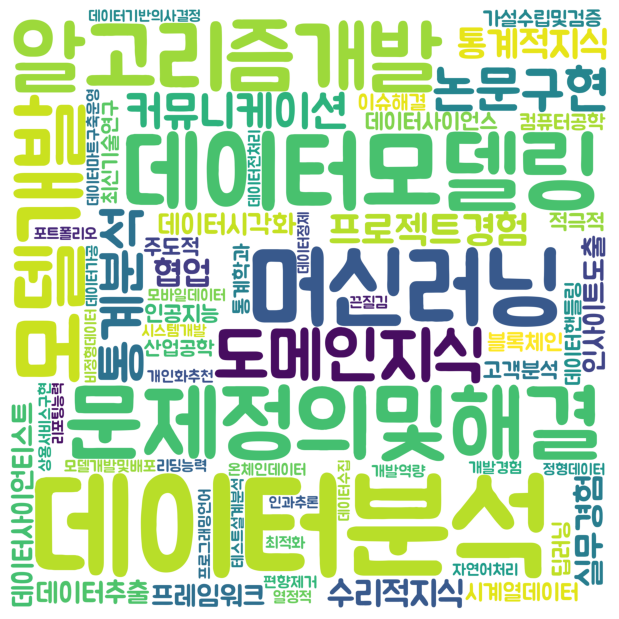

DS: Preference


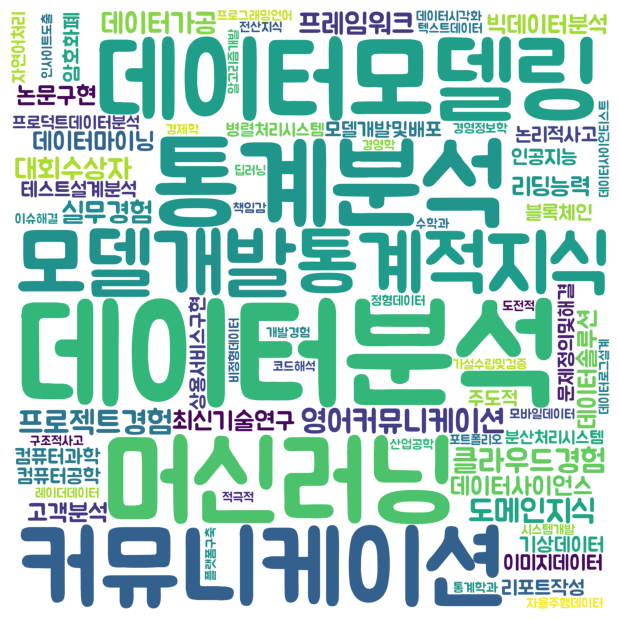

DA: Requirement


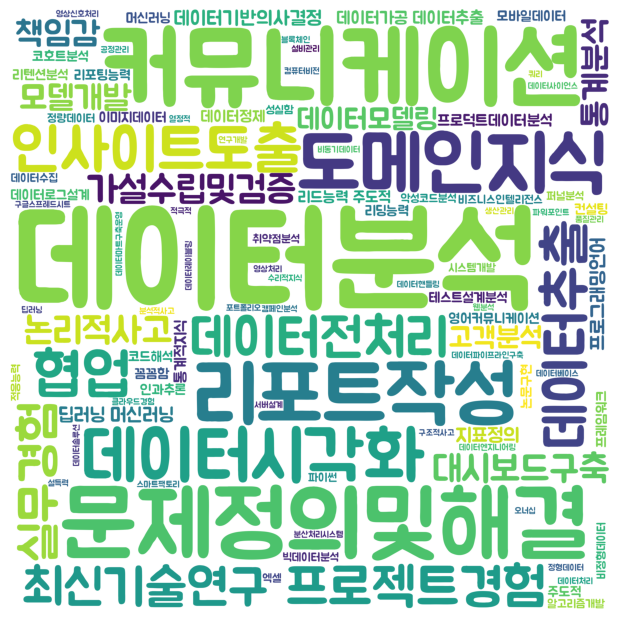

DA: Preference


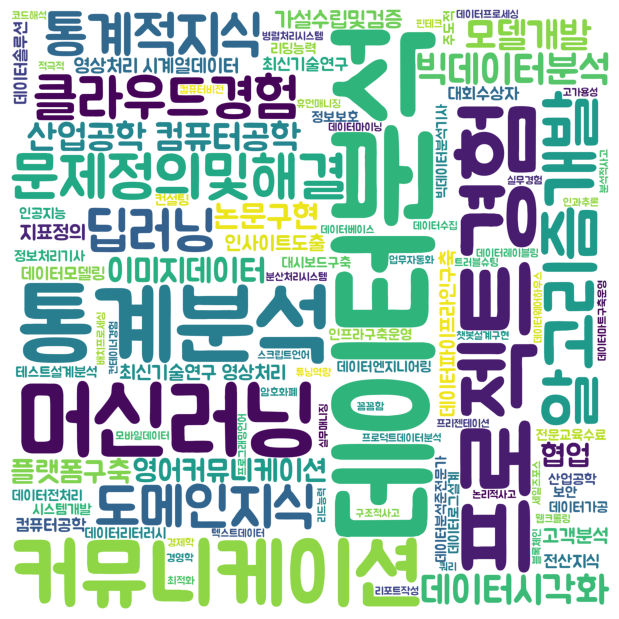

DE: Requirement


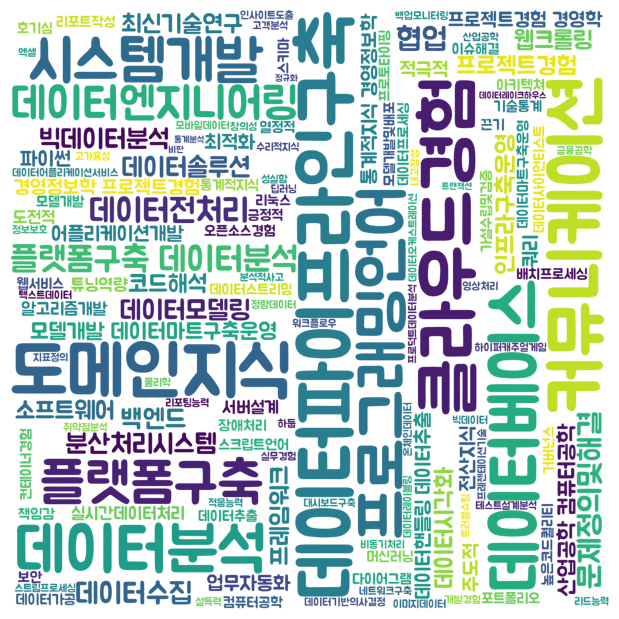

DE: Preference


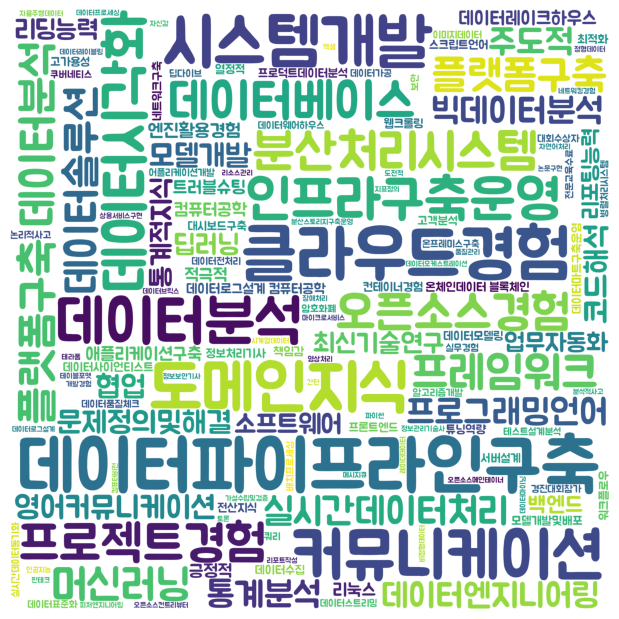

In [10]:
# 워드클라우드

def wordcloud_show(list):
    join_test1 = ', '.join(list)
    test1_list = [join_test1]
    # print(test1_list)

    font_path = '/Users/LG/AppData/Local/Microsoft/Windows/Fonts/BMJUA_ttf.ttf'
    test1_wc = ', '.join(test1_list)
    test1_wc = test1_wc.replace(' ', '').replace(',', ', ')

    wordcloud = WordCloud(
        width=2500, 
        height=2500, 
        background_color='white',
        # colormap='seismic',
        font_path=font_path
    ).generate(test1_wc)
    plt.figure(figsize=(6, 6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# DS
# Requirement
print('DS: Requirement')
test1 = df.loc[df.label == '데이터 사이언티스트'].iloc[:, 4].tolist()
wordcloud_show(test1)
# Preference
print('DS: Preference')
test1 = df.loc[df.label == '데이터 사이언티스트'].iloc[:, 6].tolist()
wordcloud_show(test1)

# DA
# Requirement
print('DA: Requirement')
test1 = df.loc[df.label == '데이터 애널리스트'].iloc[:, 4].tolist()
wordcloud_show(test1)
# Preference
print('DA: Preference')
test1 = df.loc[df.label == '데이터 애널리스트'].iloc[:, 6].tolist()
wordcloud_show(test1)

# DE
# Requirement
print('DE: Requirement')
test1 = df.loc[df.label == '데이터 엔지니어'].iloc[:, 4].tolist()
wordcloud_show(test1)
# Preference
print('DE: Preference')
test1 = df.loc[df.label == '데이터 엔지니어'].iloc[:, 6].tolist()
wordcloud_show(test1)

---

## **영어: Requirement, Preference, StackTool**

- 회의 결과, `StackTool`에서의 한글은 `Requirement_KOR`, `Preference_KOR`에도 있는 내용이어서 제거하기로 함

In [3]:
stack = df.StackTool.tolist()

stack2 = []
for sta in stack:
    new_str = sta.replace('\n', ' ').replace(',', ' ')
    new_str2 = new_str.split()
    new_str3 = ', '.join(new_str2)
    stack2.append(new_str3)
print(stack2)


# Kor, Eng 분리
kor_list = []
eng_list = []
for sta in stack2:
    kor_match = re.findall(r'[가-힣]+', sta)
    eng_match = re.findall(r'[a-zA-Z0-9.]+', sta)
    kor_list.extend(kor_match)
    eng_list.extend(eng_match)
print(kor_list)
print(eng_list)


# stack2 = []
# for idx in range(0, df.shape[0]):
#     str = stack[idx]
#     new_str = re.sub('\n', ' ', str)
#     new_str2 = re.sub(r'[^\uAC00-\uD7A3a-zA-Z0-9\s]', ' ', new_str)
#     new_str3 = re.split(' ', new_str2)
#     new_str4 = ' '.join(filter(None, new_str3))
#     stack2.append(new_str4)
#     # print(f'{idx}. {stack2[idx]}')
# stack2_df = pd.DataFrame({'stack': stack2})
# stack2_df

['Pytorch, Tensorflow, Python', 'Hadoop, MongoDB, MySQL, Spark, Python, R, Tableau, Jenkins, PostgreSQL, Neo4j', 'Hadoop, MongoDB, MySQL, Spark, Python, R, Tableau, Jenkins, PostgreSQL, Neo4j', 'Azure, AWS, GCP', 'GitLab, CSS, TypeScript, React.js, Next.js', 'python, Docker, Tensorflow, Pytorch', 'python, 모델링, SQL, ml, dl', '데이터분석, SQL, 파이썬, NLP', 'React, Java, Vue.JS', '데이터분석, SQL, 파이썬, NLP', '연구개발, AI, 데이터분석, 머신러닝, 데이터사이언티스트', 'java, 데이터분석, R, hadoop, 파이썬', 'python, SQL, 머신러닝, 알고리즘', '연구개발, AI, 데이터분석, 머신러닝, 데이터사이언티스트', '데이터분석, aws, 모델링, 아이디어, Kubernetes', 'python, R, 파이썬, 데이터사이언티스트', '데이터분석, 프로토타이핑, Deep, Learning', '데이터분석, python, SQL, R, 머신러닝, 데이터, 분석, 파이썬, 딥러닝, 데이터과학자', '데이터분석, 머신러닝, 신재생에너지, 파이썬, 태양광', 'Python, R, AWS', 'Github, Android, Django, React, JavaScript, Python, AWS, GIS, ML', 'Kotlin, Spring, Framework', 'BitBucket, Git, JIRA, Azure, AWS, DevOps, ITIL, Kubernetes', 'SQL', 'Confluence, Git, JIRA, AWS', 'Zeplin, Git, Github, Trello, Android, Amazon, Web, Service, Firebase

In [9]:
# # 한글 중복 요소 제거
# kor_list_remove = list(set(kor_list))
# print(kor_list_remove)

# 영어 소문자로 통일
eng_lower = []
for eng in eng_list:
    eng_low = eng.lower()
    eng_lower.append(eng_low)

# 영어 중복 요소 제거
eng_list_remove = list(set(eng_lower))
print(eng_list_remove)

['firebase', 'airflow', 'hive', 'jquery', 'platform', 'boot', 'erp', 'mongodb', 'slack', 'qa', 'windows', 'trello', 'next.js', 'pacs', 'shell', 'pm', 'db', 'excel', 'bitbucket', 'fastapi', 'framework', 'java', 'tableau', 'elements', 'bi', 'abap', 'power', 'c', 'pl', 'docker', 'scala', 'objectivec', 'cloud', 'nestjs', 'framer', 'ssas', 'confluence', 'ml', 'aac', 'vba', 'analytics', '.net', 'amplitude', 'jira', 'aws', 'devops', 'vuejs', 'mvvm', 'notion', 'nosql', 'neo4j', 'vue.js', 'flutter', 'react.js', 'numpy', 'python', 'sas', 'nas', 'spark', 'rdbms', 'zeplin', 'git', 'risk', 'ai', 'nginx', 'jsp', 'figma', 'jpa', 'etl', 'apple', 'nlp', 'dm', 'mm', 'graphql', 'zapier', 'amazon', 'presentation', 'cra', 'oauth', 'go', 'analyst', 'css', 'django', 'nodejs', 'learning', 'oracle', 'deep', 'tensorflow', 'flask', 'css3', 'linux', 'emr', 'sharepoint', 'html', 'studio', 'crc', 'restful', 'crm', 'gcp', 'analysis', 'spring', 'itil', 'redis', 'dl', 'hl7', 'software', 'management', 'bgp', 'android',

In [13]:
with open('./Postprocessor_Custom_Nouns.txt', 'r', encoding='utf-8-sig') as file:
    L = [line.strip() for line in file.readlines()]
print(L)

['알고리즘', '통계분석', '인공지능', '머신러닝', '블록체인', '실무경험', '모델링', '개발역량', '인사이트', '딥러닝', '프레임워크', '시각화', '프로젝트', '포트폴리오', '사이언티스트', '개인화', '프로그래밍', '협업', '의사소통', '컴퓨터공학', '산업공학', '자연어', '논문', '핸들링', '전처리', '수리적', '통계적', '협력', '커뮤니케이션', '통계학과', '수학', '데이터사이언티스트', '소통', '시계열', '도메인', '문제정의', '가설검증', '파이프라인', '책임감', '문제', '레이블링', '라벨링', '가설', '해결책', '기초통계학', '의사결정', '논리적', '분석적', '데이터베이스', '보고서', '연구', '리포트', '성실', '통계학', '비즈니스', '비지니스', '최신', '주도적', '비정형', '정형', '문서', '자기소개서', '대시보드', '검증', '빅데이터', '수집', '설득', '설득력', '리포팅', '지식', '분석', '리딩', '데이터처리', '데이터분석', '웹분석', '웹', '영어', '꼼꼼', '끈질', '끈기', '문서화', '수학적', '가공', '정제', '정제하여', '리텐션', '코호트', '엔지니어링', '구글스프레드시트', '엑셀', '인텔리전스', '인과추론', '로그', '구조적', '적응', '파워포인트', '오너십', '추출', '악성코드', '취약점', '주도적', '연구개발', '컨설팅', '코드', '테스트', '제조', '스마트팩토리', '솔루션', '시스템', '공정관리', '생산관리', '품질관리', '설비관리', '이해도', '백엔드', '클라우드', '어플리케이션', '도전의식', '열정', '스크래핑', '앱서비스', '적극적', '소프트웨어', '고가용성', '내고장성', '다이어그램', '스키마', '설계', '구현', '경험', '기반', '구축', '엔지니어', '자동화', '개발경험', '플

In [14]:
# custom_nouns, stopwords 불러오기
with open('./Postprocessor_Custom_Nouns.txt', 'r', encoding='utf-8-sig') as file:
    L = [line.strip() for line in file.readlines()]
print(L)

# replace 불러오기
dict = {}
with open('./Postprocessor_Replace.txt', 'r', encoding='utf-8-sig') as file:
    for line in file:
        key, val = line.strip().split(': ')
        dict[key] = val
print(dict)

{'컨테이너화': '컨테이너 경험', '컨테이너': '컨테이너 경험', '스크립팅': '스크립트 언어', '튜닝': '튜닝 역량', '장애': '장애처리', '백앤드': '백엔드', '프로덕트': '프로덕트 데이터 분석', '이미지': '이미지 데이터', '인과': '인과추론', '레이크하우스': '데이터 레이크하우스', '분산': '분산 처리 시스템', '접근의지': '도전적', '프레젠테이션': '프레젠테이션 기술', '플랫폼': '플랫폼 구축', '솔루션': '데이터 솔루션', '서버': '서버 설계', '프로세싱': '데이터 프로세싱', '하이퍼': '하이퍼 캐주얼 게임', '비전': '컴퓨터 비전', '텍스트': '텍스트 데이터', '스크래핑': '웹크롤링', '이슈': '이슈 해결', '전산': '전산 지식', '전산학': '전산 지식', '스크립트': '스크립트 언어', '스트리밍': '데이터 스트리밍', '스트림': '스트림 프로세싱', '배치': '배치 프로세싱', '오케스트레이션': '데이터 오케스트레이션', '퀄리티': '높은 코드 퀄리티', '인프라': '인프라 구축 운영', '실시간': '실시간 데이터 처리', '빅': '빅데이터', '마트': '데이터 마트 구축 운영', '데이터마트': '데이터 마트 구축 운영', '의사': '커뮤니케이션', '의사결정': '데이터 기반 의사결정', '앱서비스': '데이터 어플리케이션 서비스', '도전': '도전적', '도전의식': '도전적', '열정': '열정적', '어플리케이션': '어플리케이션 개발', '클라우드': '클라우드 경험', '테스트': '테스트 설계 분석', '코드': '코드 해석', '취약점': '취약점 분석', '악성코드': '악성코드 분석', '적응': '적응 능력', '구조적': '구조적 사고', '로그': '데이터 로그 설계', '지표': '지표 정의', '인텔리전스': '비즈니스 인텔리전스', '엔지니어링': '데이터 엔지니어링', '리텐션': '리텐션 분석', '코호트':